In [3]:
import numpy as np                      
import pandas as pd                              
from math import sqrt
from calendar import monthrange

import matplotlib.dates as mdates
import matplotlib.pyplot as plt                  
#import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


### Parameters

In [1]:
file_path = '../data/bike_sharing_data/day.csv'

# Building a LSTM Network

## 0) Load & pre-process the data

In [4]:
df = pd.read_csv(file_path, index_col=['dteday'], parse_dates=['dteday'])
# drop the `instant` col, which is just a row counter
df = df.drop('instant', 1)

In [5]:
# Add columns with year, month, and weekday name
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Weekday Name'] = df.index.weekday_name

In [6]:
print("Dimensions of the data: ", df.shape)
df.head()

Dimensions of the data:  (731, 17)


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,Year,Month,Weekday Name
dteday,,,,,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,2011,1,Saturday
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,2011,1,Sunday
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,2011,1,Monday
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,2011,1,Tuesday
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,2011,1,Wednesday


## 1) Basic case: 1 train & test split
Predict the bike rental counts in the last 30 days after training on all days prior to the last 30 days.

#### Helper functions

In [90]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# transform train & test data to [-1 and 1]
    # the scale of the activation function for LSTMs
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
    
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

#### Fit the model

In [123]:
# extract just the count data as a pandas series
rental_count = df['cnt']

# transform data to be stationary
raw_values = rental_count.values
diff_values = difference(raw_values, 1)

# transform data to a supervised learning setup
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-30], supervised_values[-30:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 300, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
train_predictions = lstm_model.predict(train_reshaped, batch_size=1)

#### Use the model to compute the training error

In [138]:
# walk-forward validation on the train data
train_predictions_list = list()
for i in range(len(train_scaled)):
    # make one-step forecast
    X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
    # invert scaling
    yhat = invert_scale(scaler, X, train_predictions[i])
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(train_scaled)+1-i)
    # store forecast
    train_predictions_list.append(yhat)
    expected = raw_values[i + 1]
    print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
    
# # # report performance
# # train_rmse = sqrt(mean_squared_error(raw_values[1:-30], train_predictions_list))
# # print('Train RMSE: %.3f' % train_rmse)

# # # line plot of observed vs predicted
# # plt.figure(figsize=(10, 5))
# # plt.plot(raw_values[1:-30], label="True Counts")
# # plt.plot(train_predictions_list, label="Predicted Counts")

# # plt.title("Train Data: Rental Bike Counts by Day")
# # plt.xlabel('Days of the Training Set')
# # plt.ylabel('Bike Rental Counts')
# # plt.legend()
# # plt.show()

#### Predict bike rental counts for each day in the test set one at a time & compute test error

In [121]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Day=1, Predicted=4541.889974, Expected=4649.000000
Day=2, Predicted=4273.194599, Expected=6234.000000
Day=3, Predicted=5087.642110, Expected=6606.000000
Day=4, Predicted=5348.227591, Expected=5729.000000
Day=5, Predicted=4940.496041, Expected=5375.000000
Day=6, Predicted=4756.026081, Expected=5008.000000
Day=7, Predicted=4557.872750, Expected=5582.000000
Day=8, Predicted=4779.343274, Expected=3228.000000
Day=9, Predicted=3871.759471, Expected=5170.000000
Day=10, Predicted=4657.035140, Expected=5501.000000
Day=11, Predicted=4780.916873, Expected=5319.000000
Day=12, Predicted=4675.006965, Expected=5532.000000
Day=13, Predicted=4743.899193, Expected=5611.000000
Day=14, Predicted=4769.917615, Expected=5047.000000
Day=15, Predicted=4503.291643, Expected=3786.000000
Day=16, Predicted=3973.800282, Expected=4585.000000
Day=17, Predicted=4207.765754, Expected=5557.000000
Day=18, Predicted=4642.014368, Expected=5267.000000
Day=19, Predicted=4508.564944, Expected=4128.000000
Day=20, Predicted=401

Test RMSE: 1104.819


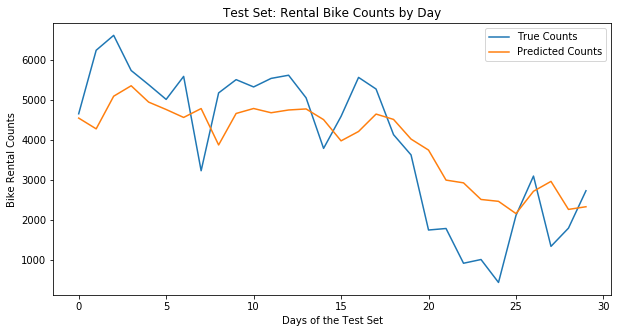

In [122]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-30:], predictions))
print('Test RMSE: %.3f' % rmse)

# line plot of observed vs predicted
plt.figure(figsize=(10, 5))
plt.plot(raw_values[-30:], label="True Counts")
plt.plot(predictions, label="Predicted Counts")

plt.title("Test Set: Rental Bike Counts by Day")
plt.xlabel('Days of the Test Set')
plt.ylabel('Bike Rental Counts')
plt.legend()
plt.show()

## 2) Using walk-forward validation to backtest our model

For getting a sense of RMSE/MSE at multiple points in time (i.e., backtesting model performance).

Train RMSE: 3678.206
Test RMSE: 824.106


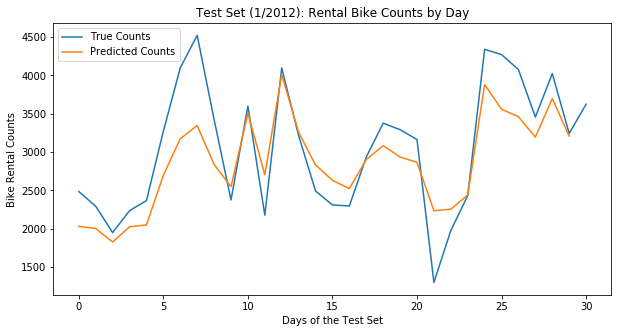

Train RMSE: 3645.484
Test RMSE: 835.732


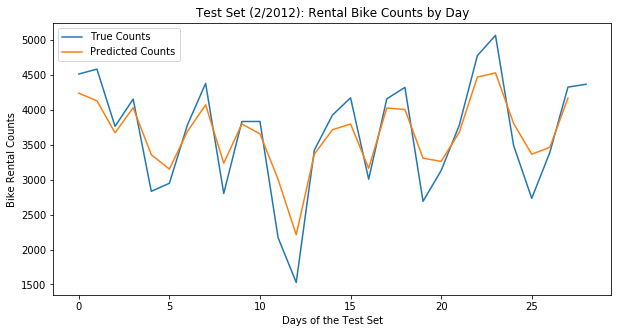

Train RMSE: 3646.288
Test RMSE: 1328.784


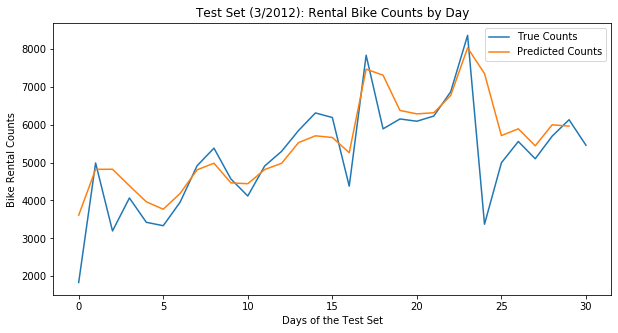

Train RMSE: 3797.298
Test RMSE: 1409.761


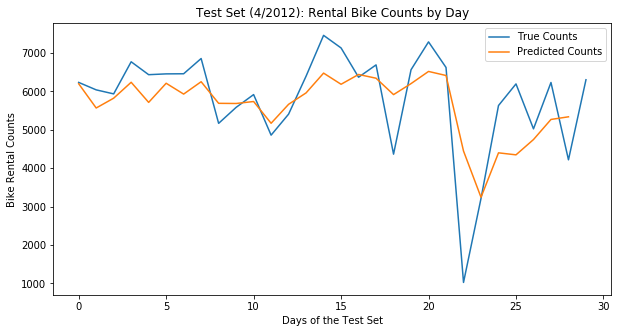

Train RMSE: 3964.269
Test RMSE: 1137.509


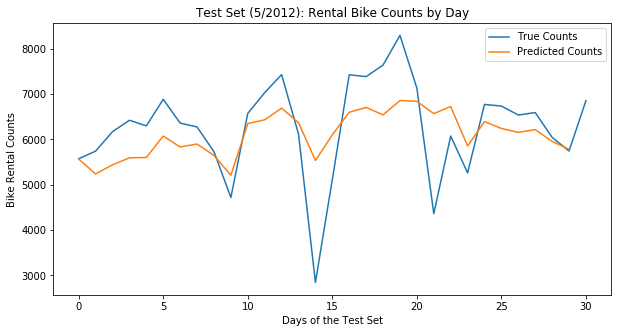

Train RMSE: 4151.779
Test RMSE: 976.076


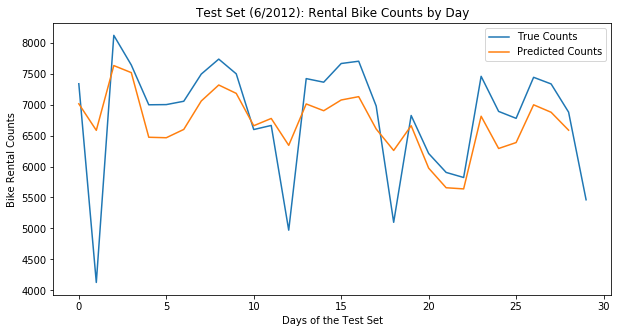

Train RMSE: 4341.688
Test RMSE: 808.125


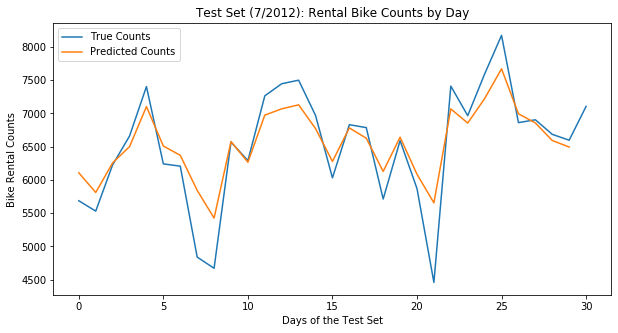

Train RMSE: 4493.796
Test RMSE: 860.348


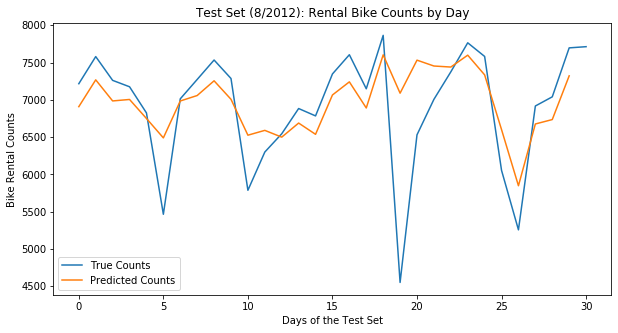

Train RMSE: 4651.477
Test RMSE: 926.457


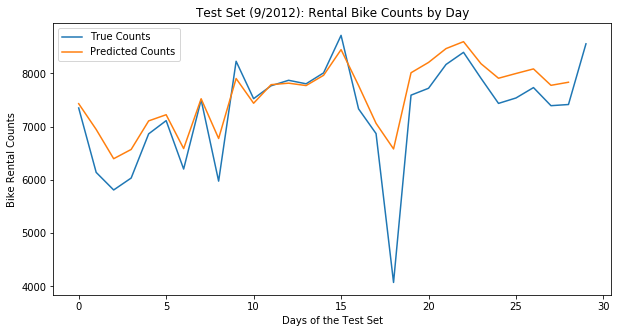

Train RMSE: 4812.363
Test RMSE: 1796.845


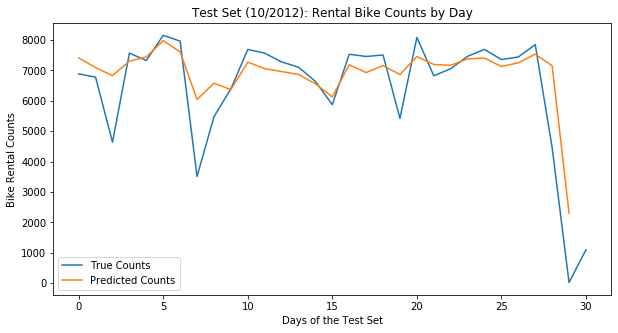

Train RMSE: 4915.482
Test RMSE: 1101.901


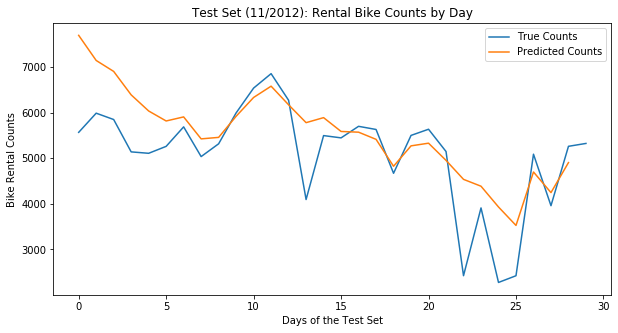

Train RMSE: 4928.468
Test RMSE: 1235.329


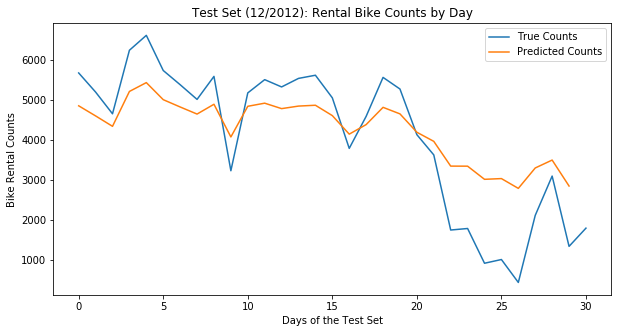

In [132]:
# how many days to use in the training set initially
days = 364 

# to store the model's predictions
predicted_dict = {}

# to store the model's performance
all_rmse = []
train_rmse_list = []

# iterate through the 12 months of 2012
for i in range(1, 13):
    # get the # of days in the month of interest
    test_days = monthrange(2012, i)[1]
    # add it to the days used for training
    days += test_days 
    # isolate just the train and test data
    raw_values = rental_count[:days].values
    
    # transform data to be stationary
    diff_values = difference(raw_values, 1)

    # transform data to a supervised learning setup
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values

    # split data into train and test-sets
    train, test = supervised_values[0:-(test_days-1)], supervised_values[-(test_days-1):]

    # transform the scale of the data
    scaler, train_scaled, test_scaled = scale(train, test)

    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 300, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    train_predictions = lstm_model.predict(train_reshaped, batch_size=1)
    
    # walk-forward validation on the train data
    train_predictions_list = list()
    for j in range(len(train_scaled)):
        X, y = train_scaled[j, 0:-1], train_scaled[j, -1]
        # invert scaling
        yhat = invert_scale(scaler, X, train_predictions[j])
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(train_scaled)+1-j)
        # store forecast
        train_predictions_list.append(yhat)
        
    # report train performance
    train_rmse = sqrt(mean_squared_error(raw_values[1:-(test_days-1):], train_predictions))
    print('Train RMSE: %.3f' % train_rmse)
    train_rmse_list.append(rmse)

    
    # walk-forward validation on the test data
    predictions = list()
    for j in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[j, 0:-1], test_scaled[j, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-j)
        # store forecast
        predictions.append(yhat)
    # store predictions (storing it in 2 ways)    
    predicted_dict[i] = predictions
    
    # report test performance
    rmse = sqrt(mean_squared_error(raw_values[-(test_days-1):], predictions))
    print('Test RMSE: %.3f' % rmse)
    all_rmse.append(rmse)
    
    # line plot of observed vs predicted
    plt.figure(figsize=(10, 5))
    plt.plot(raw_values[-test_days:], label="True Counts")
    plt.plot(predictions, label="Predicted Counts")
    plt.title("Test Set ({i}/2012): Rental Bike Counts by Day".format(i=i))
    plt.xlabel('Days of the Test Set')
    plt.ylabel('Bike Rental Counts')
    plt.legend()
    plt.show()

In [141]:
# Test RMSE
print("Test RMSE: ", np.mean(all_rmse))

Test RMSE:  1103.4144585656222
